# Preparação do ambiente

## Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import warnings

# from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from os import path as osp
# from tqdm.auto import tqdm
from unicodedata import normalize
# from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Constantes e funções auxiliares

In [2]:
FILE_LABELS_RESULTS = '../datasets/samples_labeling/issues_fiscaliza/20240423/results/labels.parquet'
FILE_MODEL = '../datasets/model/sgd_model_20240423.pkl'

In [3]:
def clean_text(doc, return_tokens=False, nltk_tokenizer=True):

    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(string.punctuation))
    
    # stopwords específicas do domínio
    # stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", relevante para o domínio
    # primeira rodada de classificação demonstrou que não foi uma boa escolha
    # testes nessa rodada confirmaram que não faz difença
    # stop_words.remove('sem')

    doc = doc.lower()

    # normalize docs
    doc = normalize('NFKD', doc).encode('ASCII', 'ignore').decode('ASCII')
    # normalize stopwords
    stop_words = [normalize('NFKD', word).encode('ASCII', 'ignore').decode('ASCII') for word in stop_words]
    
    # word regularization
    # wi-fi
    pattern = 'wi.fi'
    doc = re.sub(pattern, 'wifi', doc)
    
    # 2.4g and variations
    pattern = '2[.,]4(?:[0-9]+)?g(?:hz)?' 
    doc = re.sub(pattern, '2_4ghz', doc)
    # Scikit vectorizers remove punctuations between characters, so
    # to prevent 2.4g becomes 4g, remove punctuation early
    
    # 5.8g and variations
    pattern = '5[.,]8(?:[0-9]+)?g(?:hz)?' 
    doc = re.sub(pattern, '5_8ghz', doc)
    # Scikit vectorizers remove punctuations between characters, so
    # to prevent 5.8g becomes 8g, remove punctuation early

    if nltk_tokenizer:
        # nltk tokenizer
        tokens = [token for token in word_tokenize(doc, language='portuguese') if token not in stop_words]
    else:
        # CountVectorizer token pattern
        pattern = r'\b\w\w+\b'
        tokens = [token for token in re.findall(pattern,doc) if token not in stop_words]

    if return_tokens:
        return tokens
    else:
        return ' '.join(tokens)

In [4]:
# def load_sch(sch_database_file):
    
#     # load SCH database
#     usecols = [0,1,11,12,13,14,15]
#     dtype = {'Número de Homologação': 'str'}
#     parse_dates = [0]
#     date_format = '%d/%m/%Y'

#     df_sch = pd.read_csv(
#         sch_database_file,
#         sep=';',
#         usecols=usecols,
#         dtype=dtype,
#         parse_dates=parse_dates,
#         date_format=date_format
#         )

#     df_sch = df_sch.sort_values(by='Data da Homologação',ascending=False)

#     df_modelo = df_sch[['Número de Homologação','Modelo']].dropna()
#     df_modelo = df_modelo.groupby('Número de Homologação',as_index=False)['Modelo'].apply(lambda x: ' | '.join(x))

#     df_nome_comercial = df_sch[['Número de Homologação','Nome Comercial']].dropna()
#     df_nome_comercial = df_nome_comercial.groupby('Número de Homologação',as_index=False)['Nome Comercial'].apply(lambda x: ' | '.join(x))

#     columns_to_keep = ['Data da Homologação', 'Número de Homologação', 'Nome do Fabricante', 'Categoria do Produto', 'Tipo do Produto']
#     df_sch = df_sch[columns_to_keep]
#     df_sch = df_sch.drop_duplicates(subset='Número de Homologação')

#     df_sch = df_sch.merge(df_modelo,how='left')
#     df_sch = df_sch.merge(df_nome_comercial,how='left')
#     df_sch = df_sch.fillna('')
    
#     df_sch = df_sch.reset_index(drop=True)
    
#     return df_sch 

# Carga e prepação dos dados

In [5]:
df_items = pd.read_parquet(FILE_LABELS_RESULTS)
df_items['doc'] = df_items['titulo'].map(clean_text)
df_items['tokens'] = df_items['titulo'].apply(lambda doc: clean_text(doc, return_tokens=True))

columns_to_keep = ['id', 'titulo', 'doc', 'tokens', 
                   'titulo_bem_elaborado', 'titulo_identifica_produto',
                   'passivel_homologacao', 'transmissor_rf', 'tipo_produto']

df_items = df_items[columns_to_keep]

docs = df_items[df_items['passivel_homologacao']<=1]['titulo']
labels = df_items[df_items['passivel_homologacao']<=1]['passivel_homologacao']

df_items

,id,titulo,doc,tokens,titulo_bem_elaborado,titulo_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto
0,125728,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,streaming box tucson 2018 2022 carplay 4g wifi...,"[streaming, box, tucson, 2018, 2022, carplay, ...",1,1,1,1,TV Box/TV Stick
1,125729,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,smartphone motorola moto g52 xt2221-1 dual sim...,"[smartphone, motorola, moto, g52, xt2221-1, du...",1,1,1,1,Smartphones
2,125730,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,notebook dell latitude 7490 i5 8a ger ddr4 16g...,"[notebook, dell, latitude, 7490, i5, 8a, ger, ...",1,1,1,1,Computador ou notebook
3,125731,"Mini rede sem fio, placa de rede sem fio USB 3...",mini rede fio placa rede fio usb 3.0 adaptador...,"[mini, rede, fio, placa, rede, fio, usb, 3.0, ...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4,125732,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...",fone bluetooth tws kaidi kd-771 5.1 touch prov...,"[fone, bluetooth, tws, kaidi, kd-771, 5.1, tou...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
...,...,...,...,...,...,...,...,...,...
19004,125716,Conector de cauda de celular 10 pcs carregando...,conector cauda celular 10 pcs carregando conec...,"[conector, cauda, celular, 10, pcs, carregando...",1,1,0,0,Outro tipo/categoria (não listada acima)
19005,125717,Avantree Medley Clear - Fones de ouvido sem fi...,avantree medley clear fones ouvido fio ouvir t...,"[avantree, medley, clear, fones, ouvido, fio, ...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
19006,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",hilitand adaptador fio placa rede fio adaptado...,"[hilitand, adaptador, fio, placa, rede, fio, a...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
19007,125707,Drone Vectron Quadricoptero Tamanho G - Polibrinq,drone vectron quadricoptero tamanho g polibrinq,"[drone, vectron, quadricoptero, tamanho, g, po...",1,1,1,1,Drone


In [6]:
# sch_database_file = r'Z:\anatel\inova-fiscaliza\certificacao-homologacao\schwebsearch\datasets\sch_database\produtos_certificados.zip'
# df_sch = load_sch(sch_database_file)
# df_sch.head()

In [7]:
# dtype = {'Número de Homologação': 'str'}

# file_celulares_ean = r'Z:\anatel\inova-fiscaliza\dados-pacp\datasets\lista_celulares_homologados_ean.xlsx'
# df_celulares_ean = pd.read_excel(file_celulares_ean,dtype=dtype)
# df_celulares_ean.head()

In [8]:
# file_anuncios = r'Z:\anatel\inova-fiscaliza\dados-pacp\datasets\ml-2024-06-18_113557-2024-06-18_183335.parquet.gzip'
# df_anuncios = pd.read_parquet(file_anuncios)
# df_anuncios

# Treinamento do Classificador

## Classificador com melhores parâmetros

In [9]:
target_names = ['Não passíveis de homologação','Passíveis de homologação']
target_names_confusion = ['Não passíveis\nde homologação','Passíveis\nde homologação']

stop_words = stopwords.words('portuguese')
stop_words.extend(stopwords.words('english'))

Accuracy of SGD classifier on training set: 0.996
Accuracy of SGD classifier on test set: 0.921
AUC of SGD classifier on training set: 1.000
AUC of SGD classifier on test set: 0.972

                              precision    recall  f1-score   support

Não passíveis de homologação       0.93      0.88      0.90      1856
    Passíveis de homologação       0.92      0.95      0.93      2530

                    accuracy                           0.92      4386
                   macro avg       0.92      0.92      0.92      4386
                weighted avg       0.92      0.92      0.92      4386

CPU times: total: 3.19 s
Wall time: 2.27 s


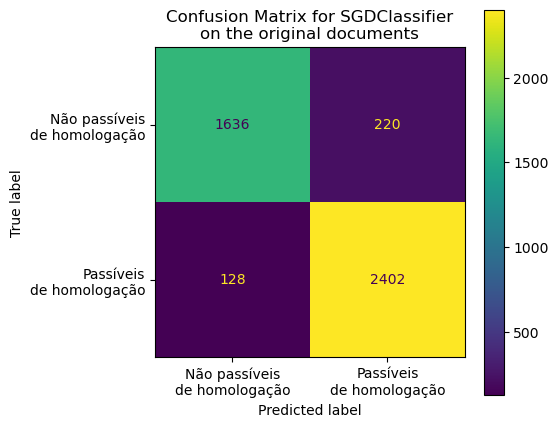

In [10]:
%%time
# vetorizar as palavras por contagem
vectorizer = CountVectorizer(ngram_range=(1,2),stop_words=stop_words)

# transformar vetores aplicando TF-IDF
transformer = TfidfTransformer()

# classificardor SGD
clf = SGDClassifier(alpha=1e-5, loss='log_loss', penalty='l2')

# juntar tudo em pipeline
pipe = Pipeline(steps=[('vectorizer',vectorizer),('transformer',transformer),('clf',clf)])

docs = df_items[df_items['passivel_homologacao']<=1]['titulo']
labels = df_items[df_items['passivel_homologacao']<=1]['passivel_homologacao']

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.25, random_state=123)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)

predicted = pipe.predict(X_test)

print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(pipe.score(X_train, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(pipe.score(X_test, y_test)))
print('AUC of SGD classifier on training set: {:.3f}'
     .format(roc_auc_score(y_train,pipe.predict_proba(X_train)[:,1])))
print('AUC of SGD classifier on test set: {:.3f}'
     .format(roc_auc_score(y_test,pipe.predict_proba(X_test)[:,1])))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)
_ = ax.set_title(f"Confusion Matrix for {pipe['clf'].__class__.__name__}\non the original documents")

In [11]:
predicted = pipe.predict(X_test)
y_scores = pipe.decision_function(X_test)
auc_sgd = roc_auc_score(y_test,pipe.predict_proba(X_test)[:,1])

precisons,recalls,precisions_recalls_thresholds = precision_recall_curve(y_test,y_scores)
fpr,tpr,auc_thresholds = roc_curve(y_test,y_scores)

## Persistir modelo

In [12]:
from pickle import dump
with open(FILE_MODEL, "wb") as f:
    dump(pipe, f, protocol=5)